# Caffeine Odour Learning Y-maze

## Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [3]:
ELP = read.csv2("./Data/ELP_14_Caffeine_odour_learning_Y_maze.csv")
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Solution,Reward_Odour,Reward_Side,Initial_Decision,Final_Decision,Number_Relocations,Nest_Duration,Trophallaxis,Full
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,17.08.22,14:20,Alexandra Koch,25.4,21st April - Spain,4-days,9,11,1,R,Strawberry,R,R,R,0,986,NA,No


## Get a binary right/wrong of initial and final decision and check how many ants switched between their initial and final decision

In [4]:
ELP$Initial_Binary = ifelse(ELP$Initial_Decision == ELP$Reward_Side, 1, 0)
ELP$Final_Binary = ifelse(ELP$Final_Decision == ELP$Reward_Side, 1, 0)
ELP$Switched_Binary = ifelse(ELP$Initial_Binary == ELP$Final_Binary, 0, 1)

## Unblind solutions

In [5]:
ELP$Solution = ifelse(ELP$Solution == "W", "Caffeine", "Control")

## Sample size

In [6]:
table(ELP$Reward_Odour, ELP$Reward_Side, ELP$Solution)

, ,  = Caffeine

            
              L  R
  Apple      12 12
  Strawberry 12 12

, ,  = Control

            
              L  R
  Apple      12 12
  Strawberry 12 12


## Ensure relevant variables are factors

In [7]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Odour = as.factor(ELP$Reward_Odour)
ELP$Reward_Side = as.factor(ELP$Reward_Side)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Do initial and final choices significantly differ?

In [8]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))
ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.239 0.124 Inf    1  -2.753  0.0059

Tests are performed on the log odds ratio scale 

p-value < 0.05 therefore there is a significant difference between initial and final decisions.

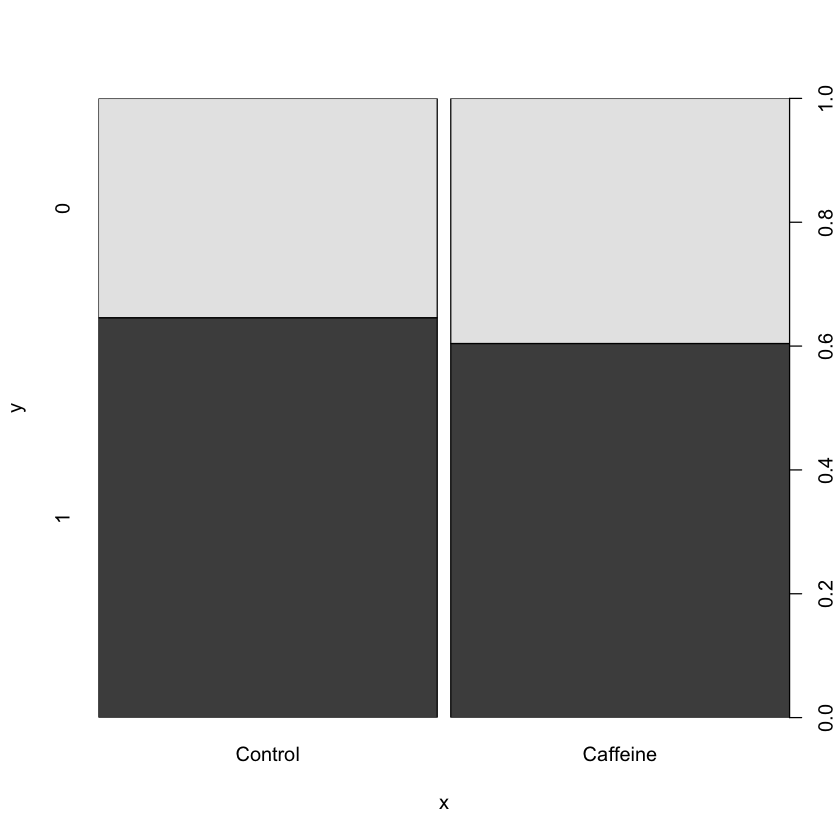

In [9]:
plot(ELP$Solution, ELP$Initial_Binary)

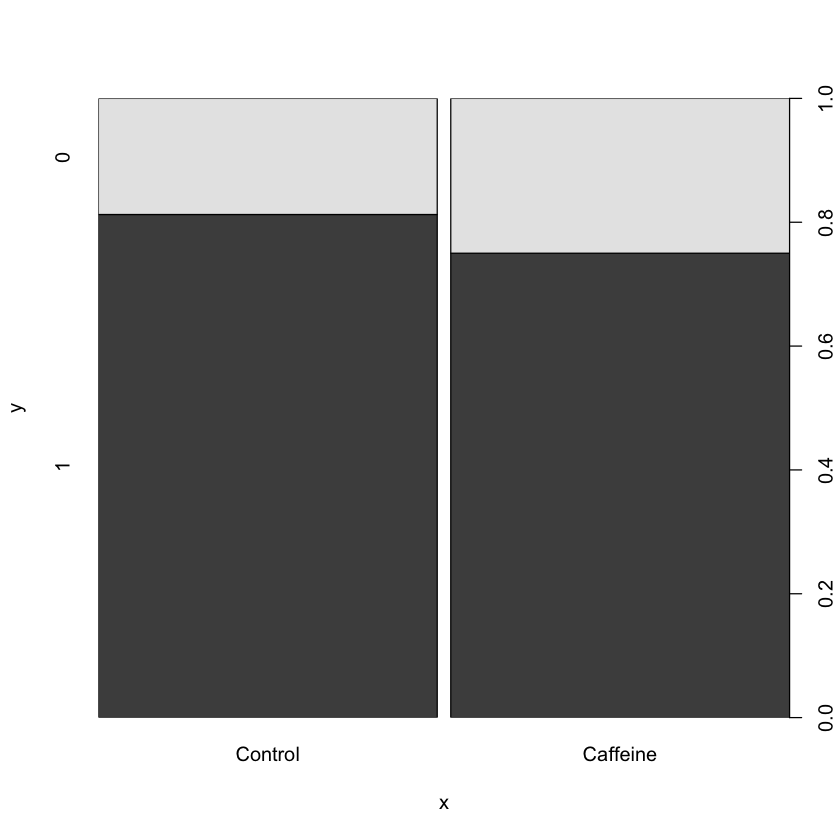

In [10]:
plot(ELP$Solution, ELP$Final_Binary)

**There is around a 20% difference between the number of ants that choose the reward side as their initial and final choice. Since the number of ants that choose the reward side is 20% higher in final decision this suggests that ants are correcting their choice during the visit before they reach the solution. Therefore we use final choice as we are interested in their memory and if they switch it implies they know that they were going on the unrewarded side.**

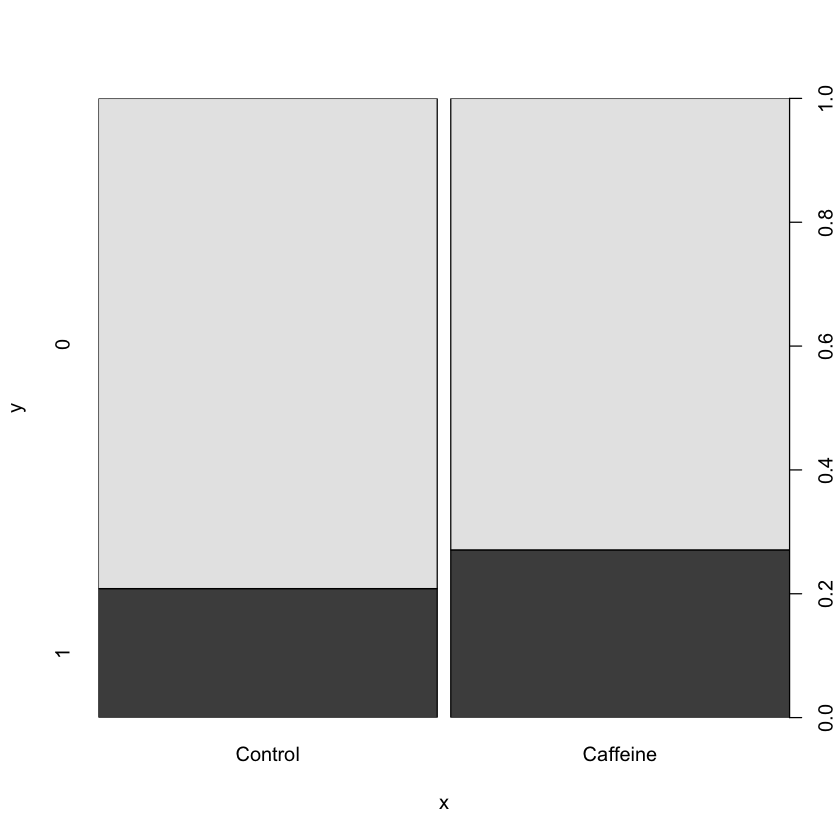

In [11]:
plot(ELP$Solution, as.factor(ELP$Switched_Binary))

**There seems to be no difference between the number of ants that switch between initial and final choice between treatments.**

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [12]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [13]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [14]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Odour model
**Biological hypothesis:** Ants have an innate preference towards an odour.

In [15]:
odour_mod = glmer(Final_Binary ~ Reward_Odour + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [16]:
max_mod = glmer(Final_Binary ~ Solution + Reward_Side + Reward_Odour + (1|Collection_Date) + (1|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Check if the most complex model (max_mod) is a good fit to the data

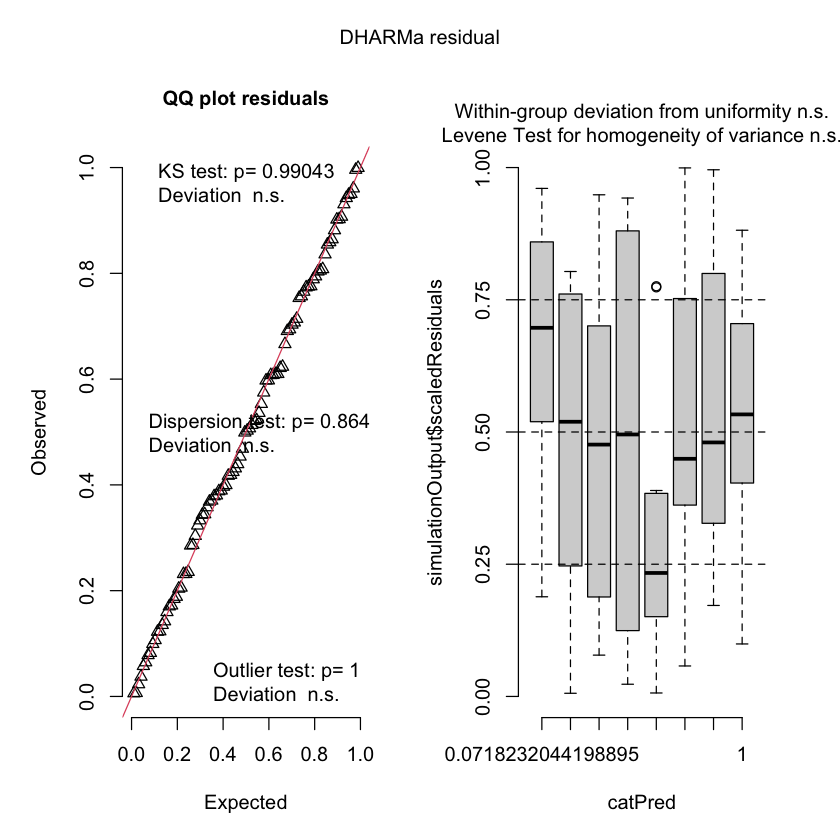

In [17]:
simres = simulateResiduals(max_mod)
plot(simres, asFactor = T)

The maximum model seems to hold all assumptions and be a god fit to the data. Therefore, all simpler models should be equally good.
## Model Selection

In [18]:
cand_models = list("null_mod" = null_mod, 
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "odour_mod" = odour_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_mod,4,109.1643,0.000000,1.00000000,0.46255159,-50.36239,0.4625516
2,solution_mod,5,110.8627,1.698326,0.42777283,0.19786700,-50.09800,0.6604186
4,odour_mod,5,111.2853,2.120914,0.34629758,0.16018050,-50.30930,0.8205991
3,side_mod,5,111.3165,2.152136,0.34093349,0.15769933,-50.32491,0.9782984
5,max_mod,7,115.2831,6.118746,0.04691711,0.02170158,-50.00518,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_mod,4,109.1643,0.000000,1.0000000,0.4625516,-50.36239,0.4625516
2,solution_mod,5,110.8627,1.698326,0.4277728,0.1978670,-50.09800,0.6604186
4,odour_mod,5,111.2853,2.120914,0.3462976,0.1601805,-50.30930,0.8205991
3,side_mod,5,111.3165,2.152136,0.3409335,0.1576993,-50.32491,0.9782984


**The null_mod explains 46% of the total variance explained by all of the models tested.**

In [19]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'null_mod' and 'solution_mod':
2.34

The null model is 2 times more parsimonious than the next "best" model (solution_mod).

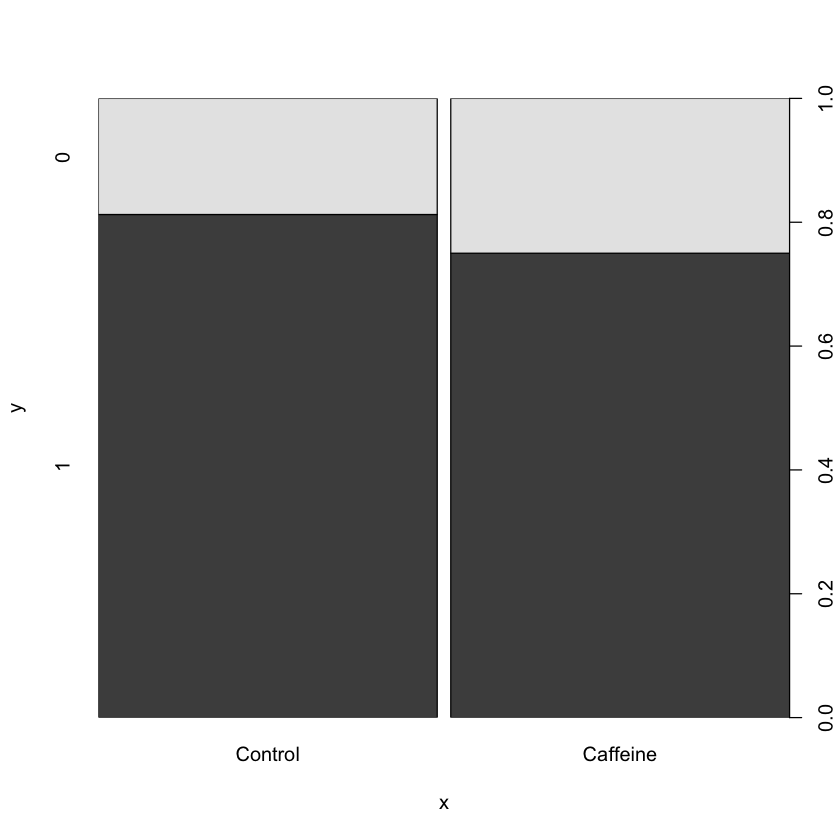

In [20]:
plot(ELP$Solution, ELP$Final_Binary)

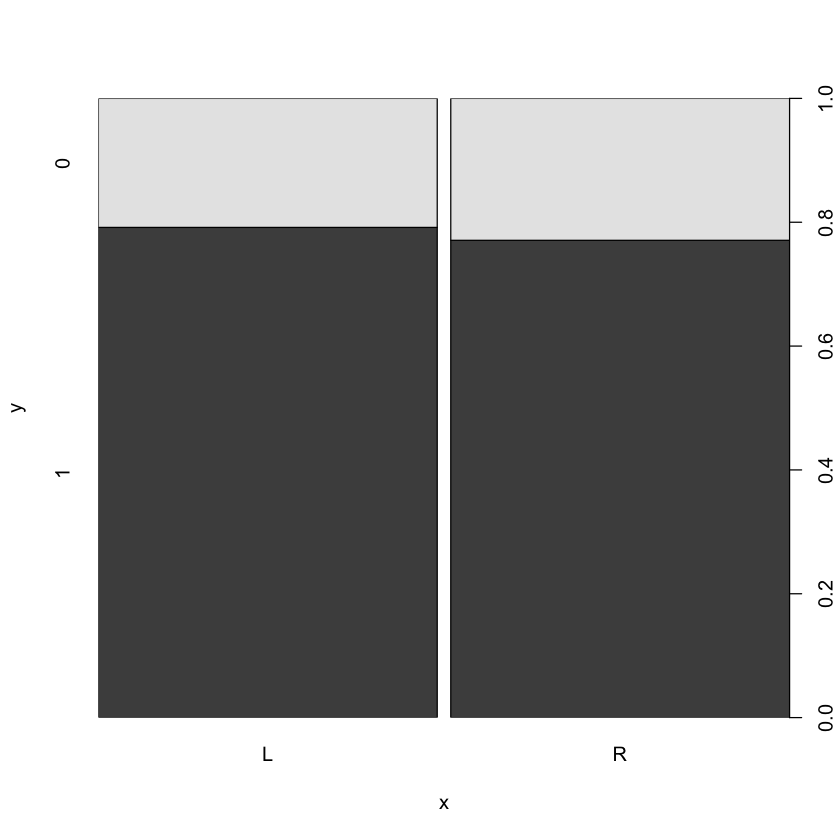

In [21]:
plot(ELP$Reward_Side, ELP$Final_Binary)

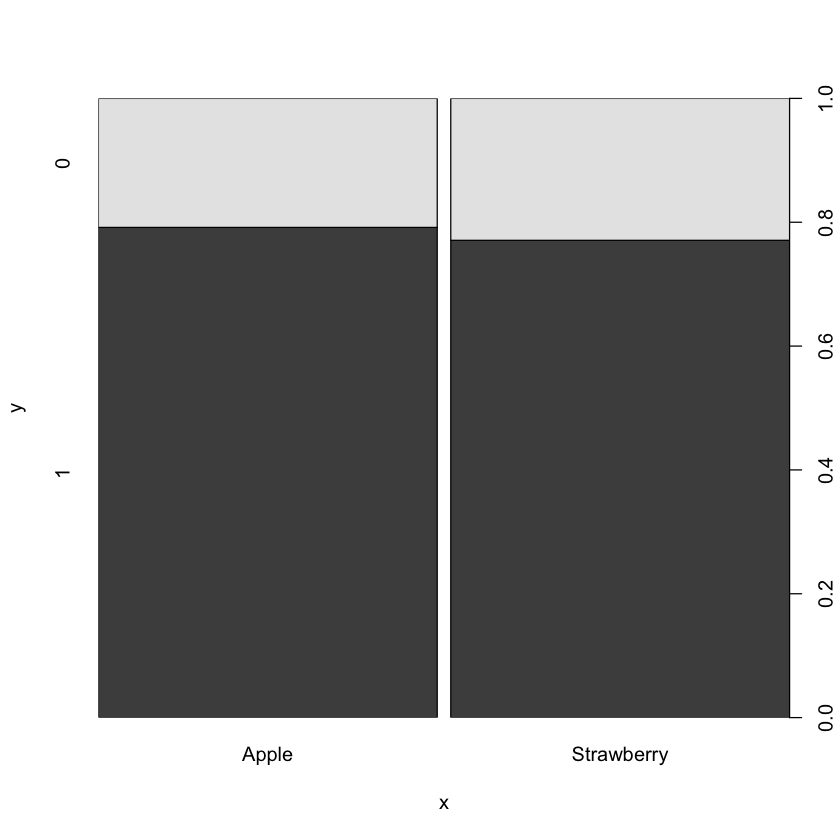

In [22]:
plot(ELP$Reward_Odour, ELP$Final_Binary)

## Initial Conclusions
- Solution seems to not have an effect on choice.
- Side seems to not have an effect on choice.
- Odour seems to not have an effect on choice.

## Brain lateralisation VS Visual Cues
**This setup had the wall on the Left!**

## Model averaging

In [23]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_mod,4,109.1643,0.000000,1.0000000,0.4625516,-50.36239,0.4625516
2,solution_mod,5,110.8627,1.698326,0.4277728,0.1978670,-50.09800,0.6604186
4,odour_mod,5,111.2853,2.120914,0.3462976,0.1601805,-50.30930,0.8205991
3,side_mod,5,111.3165,2.152136,0.3409335,0.1576993,-50.32491,0.9782984


There is no clearly better model!

In [24]:
top_models = list("null_mod" = null_mod, 
                   "solution_mod" = solution_mod,
                   "odour_mod" = odour_mod,
                   "side_mod" = side_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavgShrink(top_models, parm = "SolutionCaffeine")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "Reward_OdourStrawberry")

Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,4,109.1643,0.000000,1.0000000,0.4728124,-50.36239,1.311686,0.3062711
solution_mod,5,110.8627,1.698326,0.4277728,0.2022563,-50.09800,1.498966,0.4078067
odour_mod,5,111.2853,2.120914,0.3462976,0.1637338,-50.30930,1.404561,0.4291338
side_mod,5,111.3165,2.152136,0.3409335,0.1611976,-50.32491,1.382733,0.4059587


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,4,109.1643,0.000000,1.0000000,0.4728124,-50.36239,0.0000000,0.0000000
solution_mod,5,110.8627,1.698326,0.4277728,0.2022563,-50.09800,-0.3624844,0.4999642
odour_mod,5,111.2853,2.120914,0.3462976,0.1637338,-50.30930,0.0000000,0.0000000
side_mod,5,111.3165,2.152136,0.3409335,0.1611976,-50.32491,0.0000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,4,109.1643,0.000000,1.0000000,0.4728124,-50.36239,0.0000000,0.0000000
solution_mod,5,110.8627,1.698326,0.4277728,0.2022563,-50.09800,0.0000000,0.0000000
odour_mod,5,111.2853,2.120914,0.3462976,0.1637338,-50.30930,0.0000000,0.0000000
side_mod,5,111.3165,2.152136,0.3409335,0.1611976,-50.32491,-0.1363383,0.4978865


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,4,109.1643,0.000000,1.0000000,0.4728124,-50.36239,0.0000000,0.0000000
solution_mod,5,110.8627,1.698326,0.4277728,0.2022563,-50.09800,0.0000000,0.0000000
odour_mod,5,111.2853,2.120914,0.3462976,0.1637338,-50.30930,-0.1664771,0.5116158
side_mod,5,111.3165,2.152136,0.3409335,0.1611976,-50.32491,0.0000000,0.0000000


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 4.0 [1.9, 8.2] -> **Ants do not choose an arm of the Y-maze randomly!**

**Solution** = 0.9 [0.5, 1.6] -> There is no effect of Solution!

**Side** = 1.0 [0.7, 1.5] -> There is no effect of Side!

**Odour** = 1.0 [0.6, 1.5] -> There is no effect of Odour!

## Conclusions
- Ants do not choose a random side of the Y-maze. They learn to associate the odour with the reward.
- There is no difference between the two odours.
- There is no efect of caffeine.
- There is no side bias.